# Twin Delayed Deep Deterministic Policy Gradient (TD3)

This notebook contains the implementation for TD3 model from baseline

# Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import bot3RLNav
import cv2
import gym
#import roboschool
import sys

# Networks

In [2]:
class Actor(nn.Module):
    """Initialize parameters and build model.
        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            max_action (float): highest action to take
            seed (int): Random seed
            h1_units (int): Number of nodes in first hidden layer
            h2_units (int): Number of nodes in second hidden layer
            
        Return:
            action output of network with tanh activation
    """
    
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)

        self.max_action = torch.tensor(max_action)


    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = torch.tanh(self.l3(x)) 
        return torch.mul (self.max_action, x)



In [3]:
class Critic(nn.Module):
    """Initialize parameters and build model.
        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            max_action (float): highest action to take
            seed (int): Random seed
            h1_units (int): Number of nodes in first hidden layer
            h2_units (int): Number of nodes in second hidden layer
            
        Return:
            value output of network 
    """
    
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 400)
        self.l5 = nn.Linear(400, 300)
        self.l6 = nn.Linear(300, 1)


    def forward(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xu))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)
        return x1, x2


    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)
        return x1

# Memory

In [4]:
# Code based on: 
# https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py

# Expects tuples of (state, next_state, action, reward, done)
class ReplayBuffer(object):
    """Buffer to store tuples of experience replay"""
    
    def __init__(self, max_size=1000000):
        """
        Args:
            max_size (int): total amount of tuples to store
        """
        
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        """Add experience tuples to buffer
        
        Args:
            data (tuple): experience replay tuple
        """
        
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        """Samples a random amount of experiences from buffer of batch size
        
        Args:
            batch_size (int): size of sample
        """
        
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        states, actions, next_states, rewards, dones = [], [], [], [], []

        for i in ind: 
            s, a, s_, r, d = self.storage[i]
            states.append(np.array(s, copy=False))
            actions.append(np.array(a, copy=False))
            next_states.append(np.array(s_, copy=False))
            rewards.append(np.array(r, copy=False))
            dones.append(np.array(d, copy=False))
        
        return np.array(states), np.array(actions), np.array(next_states), np.array(rewards).reshape(-1, 1), np.array(dones).reshape(-1, 1)

# Agent

In [5]:
class TD3(object):
    """Agent class that handles the training of the networks and provides outputs as actions
    
        Args:
            state_dim (int): state size
            action_dim (int): action size
            max_action (float): highest action to take
            device (device): cuda or cpu to process tensors
            env (env): gym environment to use
    
    """
    
    def __init__(self, state_dim, action_dim,min_action, max_action, env):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = torch.tensor(max_action)
        self.min_action = torch.tensor(min_action)
        self.env = env


        
    def select_action(self, state, noise=0.1):
        """Select an appropriate action from the agent policy
        
            Args:
                state (array): current state of environment
                noise (float): how much noise to add to acitons
                
            Returns:
                action (float): action clipped within action range
        
        """
        state[0]  = state[0] / 100
        state[1]  = state[1] / 100
        state[2] /= np.pi
        state[3] /= 100
        state[4] /+ np.pi
        #print("state: ",state)
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        
        action = self.actor(state).cpu().data.numpy().flatten()
        if noise != 0: 
            action = (action + np.random.normal(0, noise, size=self.env.action_space.shape[0])) 
        action = action.clip(self.env.action_space.low, self.env.action_space.high)
        #print("Action after: ",action)
        return action

    
    def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
        """Train and update actor and critic networks
        
            Args:
                replay_buffer (ReplayBuffer): buffer for experience replay
                iterations (int): how many times to run training
                batch_size(int): batch size to sample from replay buffer
                discount (float): discount factor
                tau (float): soft update for main networks to target networks
                
            Return:
                actor_loss (float): loss from actor network
                critic_loss (float): loss from critic network
        
        """
        
        for it in range(iterations):

            # Sample replay buffer 
            x, y, u, r, d = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(x).to(device)
            action = torch.FloatTensor(u).to(device)
            next_state = torch.FloatTensor(y).to(device)
            done = torch.FloatTensor(1 - d).to(device)
            reward = torch.FloatTensor(r).to(device)

            # Select action according to policy and add clipped noise 
            noise = torch.FloatTensor(u).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (self.actor_target(next_state) + noise).clamp(self.min_action , self.max_action)
            #next_action = (self.actor_target(next_state) + noise)
            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (done * discount * target_Q).detach()

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q) 

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Delayed policy updates
            if it % policy_freq == 0:

                # Compute actor loss
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

                # Optimize the actor 
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


    def save(self, filename, directory):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
        torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))


    def load(self, filename="best_avg", directory="./saves"):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
        self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

# Runner

In [6]:
class Runner():
    """Carries out the environment steps and adds experiences to memory"""
    
    def __init__(self, env, agent, replay_buffer):
        
        self.env = env
        self.agent = agent
        self.replay_buffer = replay_buffer
        self.obs = env.reset()
        self.done = False
        
    def next_step(self, episode_timesteps, noise=0.1):
        # obs_norm = self.obs
        # obs_norm[0] = self.obs[0] / 763
        # obs_norm[1] =self.obs[1] / 654
        # obs_norm[2]/= np.pi
        action = self.agent.select_action(np.array( self.obs), noise=0.1)
        # Perform action
        new_obs, reward, done, _ = self.env.step(action) 
        done_bool = 0 if episode_timesteps + 1 == 300 else 1
        #print("reward: ",reward)
        # Store data in replay buffer
        # new_obs_norm = new_obs
        # new_obs_norm[0] = new_obs[0] / 763
        # new_obs_norm[1] =new_obs[1] / 654
        # new_obs_norm[2]/= np.pi
        #reward_norm = reward/5
        replay_buffer.add((self.obs, new_obs, action, reward, done_bool))
        print("reward: ",reward, "   |   ","action: ",action,"  |   new_obs",new_obs[3])

        self.obs = new_obs
        cv2.namedWindow("bot3")
        img = env.render(mode="rgb_array")
        cv2.imshow("bot3", img)
        cv2.waitKey(50)
        if done:
            self.obs = self.env.reset()
            done = False
            
            return reward, True
        
        return reward, done

# Evaluate

In [7]:
def evaluate_policy(policy, env, eval_episodes=100,render=False):
    """run several episodes using the best agent policy
        
        Args:
            policy (agent): agent to evaluate
            env (env): gym environment
            eval_episodes (int): how many test episodes to run
            render (bool): show training
        
        Returns:
            avg_reward (float): average reward over the number of evaluations
    
    """
    
    avg_reward = 0.
    for i in range(eval_episodes):
        obs = env.reset()
        done = False
        while not done:
            if render:
                cv2.namedWindow("bot3")
                img = env.render(mode="rgb_array")
                cv2.imshow("bot3", img)
                cv2.waitKey(50)
                #env.render()
            action = policy.select_action(np.array(obs), noise=0)
            obs, reward, done, _ = env.step(action)
            avg_reward += reward
            if render: print("action: ", action,"   |   ","state: ",obs, "   |   ","reward: ",reward)
    avg_reward /= eval_episodes

    print("\n---------------------------------------")
    print("Evaluation over {:d} episodes: {:f}" .format(eval_episodes, avg_reward))
    print("---------------------------------------")
    return avg_reward

# Observation

In [8]:
def observe(env,replay_buffer, observation_steps,render= False):
    """run episodes while taking random actions and filling replay_buffer
    
        Args:
            env (env): gym environment
            replay_buffer(ReplayBuffer): buffer to store experience replay
            observation_steps (int): how many steps to observe for
    
    """
    
    time_steps = 0
    obs = env.reset()
    done = False

    while time_steps < observation_steps:
        if render:
                cv2.namedWindow("bot3")
                img = env.render(mode="rgb_array")
                cv2.imshow("bot3", img)
                cv2.waitKey(50)
                print(action,reward)
                
        action = env.action_space.sample()
        new_obs, reward, done, _ = env.step(action)
        #print("\n",reward)
        replay_buffer.add((obs, new_obs, action, reward, done))

        obs = new_obs
        time_steps += 1

        if done:
            obs = env.reset()
            done = False

        print("\rPopulating Buffer {}/{}.".format(time_steps, observation_steps), end="")
        #sys.stdout.flush()

# Train

In [9]:
def train(agent, test_env):
    """Train the agent for exploration steps
    
        Args:
            agent (Agent): agent to use
            env (environment): gym environment
            writer (SummaryWriter): tensorboard writer
            exploration (int): how many training steps to run
    
    """

    total_timesteps = 0
    timesteps_since_eval = 0
    episode_num = 0
    episode_reward = 0
    episode_timesteps = 0
    done = False 
    obs = env.reset()
    evaluations = []
    global rewards 
    best_avg = -2000
    
    writer = SummaryWriter(comment="-TD3_Baseline_HalfCheetah")
    
    while total_timesteps < EXPLORATION:
    
        if done: 

            if total_timesteps != 0: 
                rewards.append(episode_reward)
                avg_reward = np.mean(rewards[-100:])
                
                writer.add_scalar("avg_reward", avg_reward, total_timesteps)
                writer.add_scalar("reward_step", reward, total_timesteps)
                writer.add_scalar("episode_reward", episode_reward, total_timesteps)
                
                if best_avg < avg_reward:
                    best_avg = avg_reward
                    print("saving best model....\n")
                    agent.save("best_avg","saves")

                print("\rTotal T: {:d} Episode Num: {:d} Reward: {:f} Avg Reward: {:f}".format(
                    total_timesteps, episode_num, episode_reward, avg_reward))
                #sys.stdout.flush()


                if avg_reward >= REWARD_THRESH:
                    break

                agent.train(replay_buffer, episode_timesteps, BATCH_SIZE, GAMMA, TAU, NOISE, NOISE_CLIP, POLICY_FREQUENCY)

                # Evaluate episode
                if timesteps_since_eval >= EVAL_FREQUENCY:
                    timesteps_since_eval %= EVAL_FREQUENCY
                    eval_reward = evaluate_policy(agent, test_env)
                    evaluations.append(avg_reward)
                    writer.add_scalar("eval_reward", eval_reward, total_timesteps)

                    if best_avg < eval_reward:
                        best_avg = eval_reward
                        print(" => saving best model....\n")
                        agent.save("best_avg","saves")

                episode_reward = 0
                episode_timesteps = 0
                episode_num += 1 

        reward, done = runner.next_step(episode_timesteps)
        episode_reward += reward

        episode_timesteps += 1
        total_timesteps += 1
        timesteps_since_eval += 1

# Config

In [10]:
ENV = 'bot3RLNav/World-v3'
SEED = 0
OBSERVATION = 20000
EXPLORATION = 400
BATCH_SIZE = 256
GAMMA = 0.99
TAU = 0.005
NOISE = 0.5
NOISE_CLIP = 0
EXPLORE_NOISE = 0.1
POLICY_FREQUENCY = 2
EVAL_FREQUENCY = 10000
REWARD_THRESH = 8000

# Main

In [11]:
env = gym.make(ENV, map_file="data/small_map.jpg",
                   robot_file="data/small_robot.png")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds
#env.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = env.action_space.high
min_action = env.action_space.low

policy = TD3(state_dim, action_dim, min_action, max_action, env)

replay_buffer = ReplayBuffer()

runner = Runner(env, policy, replay_buffer)

total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True

/home/ahmed/.local/lib/python3.10/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/ahmed/.local/lib/python3.10/site-packages/gym/utils/env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/home/ahmed/.local/lib/python3.10/site-packages/gym/envs/registration.py:619: UserWarning: WARN: Env check failed with the following message: The observation returned by the `reset()` method does not match the given observation space
You can set `disable_env_checker=True` to disable this check.
  logger.warn(


In [12]:
# Populate replay buffer
#observe(env, replay_buffer, OBSERVATION,render=False)

In [13]:
rewards = []
# Train agent
train(policy, env)

reward:  35.87523414302646    |    action:  [ 1.5491095 -0.023237 ]   |   new_obs 30.15491092420493
reward:  -4.923165559009522    |    action:  [1.54396593 0.08486665]   |   new_obs 30.309307445724258
reward:  -5.058866548114237    |    action:  [ 0.37833125 -0.10354717]   |   new_obs 30.34714056634173
reward:  -4.692597256436515    |    action:  [ 1.54228019 -0.15424435]   |   new_obs 30.501365864879194
reward:  -4.806347480492975    |    action:  [ 1.43652138 -0.09777022]   |   new_obs 30.645007319406364
reward:  -5.023985290272419    |    action:  [1.46137482 0.0067963 ]   |   new_obs 30.791129634325955
reward:  -4.749779614293156    |    action:  [ 1.52429637 -0.12641637]   |   new_obs 30.943536406152468
reward:  -4.79304579103485    |    action:  [ 1.49241536 -0.10499806]   |   new_obs 31.092738441827944
reward:  -4.6863254417550255    |    action:  [ 1.59746341 -0.15871063]   |   new_obs 31.252415419661492
reward:  -4.556596068276448    |    action:  [ 1.47891989 -0.22336864]   

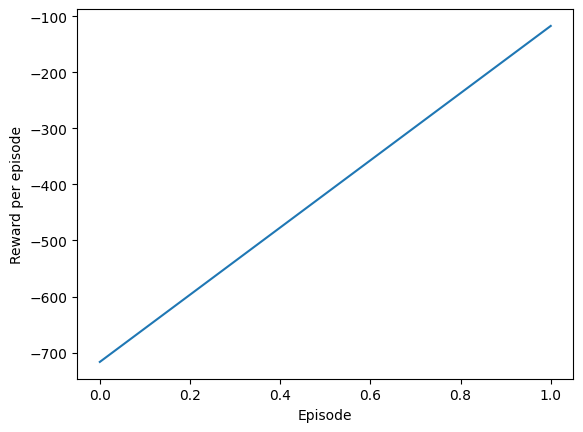

In [14]:
#plot the reward per episode 
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward per episode")
plt.show()

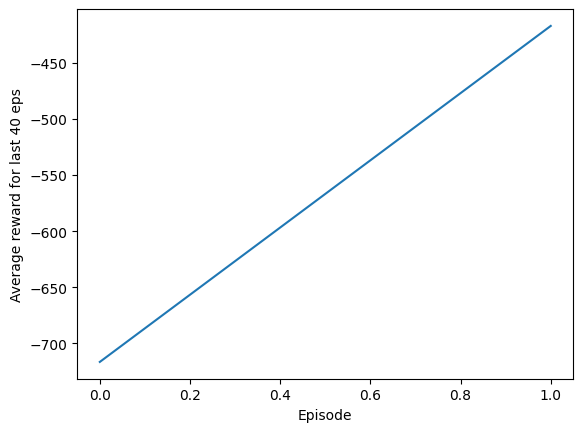

In [15]:
#plot the avg reward
window_avg = 40
avg_rewards = [np.mean(rewards[i -window_avg if i-window_avg >0 else 0 : i+1]) for i in range(len(rewards))] 
plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average reward for last {:d} eps".format(window_avg))
plt.show()

In [16]:
policy.load()

for i in range(100):
    evaluate_policy(policy, env, render=True)

action:  [ 9.338173   -0.90870637]    |    state:  [46.02121232 95.93357633  1.52536101 30.93358361  3.09684307]    |    reward:  37.62086347778145
action:  [ 9.753029  -0.9619935]    |    state:  [46.08892687 96.9065257   1.47726133 31.90664962  3.05084476]    |    reward:  -3.1467785860003277
action:  [ 9.745623   -0.96093667]    |    state:  [46.20323116 97.8743615   1.4292145  32.87498968  3.0061928 ]    |    reward:  -3.179230815170805
action:  [ 9.738258  -0.9598986]    |    state:  [46.36374076 98.83486835  1.38121957 33.83682349  2.96276595]    |    reward:  -3.197721660640181
action:  [ 9.731552   -0.95892036]    |    state:  [46.5699819  99.78591812  1.33327355 34.79058751  2.92045383]    |    reward:  -3.203459047670056
action:  [ 9.7248955  -0.95795345]    |    state:  [ 46.8213728  100.72535334   1.28537588  35.73479432   2.87915947]    |    reward:  -3.197655786582068
action:  [ 9.718514  -0.9570241]    |    state:  [ 47.11723917 101.65107378   1.23752467  36.66809829   2

KeyboardInterrupt: 

In [ ]:
env.close()

NameError: name 'env' is not defined